In [1]:
%cd ..

/volatile/home/Zaccharie/workspace/understanding-unets


In [2]:
import os.path as op
import time

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm_notebook

from learning_wavelets.data.toy_datasets import masked_kspace_ellipse_dataset
from learning_wavelets.evaluate import keras_psnr, keras_ssim
from learning_wavelets.keras_utils.fourier import tf_masked_shifted_normed_fft2d, tf_masked_shifted_normed_ifft2d
from learning_wavelets.models.ista import IstaLearnlet

In [3]:
im_size = 128
af = 1.5
kspace_ds_train = masked_kspace_ellipse_dataset(im_size, af=af, batch_size=1)
kspace_ds_val = masked_kspace_ellipse_dataset(im_size, af=af)

In [4]:
learnlet_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'n_tiling': 16, 
        'mixing_details': False,    
        'skip_connection': True,
        'kernel_size': 7,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
        'kernel_size': 9,
    },
    'threshold_kwargs':{
        'noise_std_norm': False,
        'alpha_init': 0.1,
    },
    'n_scales': 3,
    'exact_reconstruction': True,
    'undecimated': True,
    'clip': False,
}

model = IstaLearnlet(
    n_iterations=10,
    forward_operator=tf_masked_shifted_normed_fft2d,
    adjoint_operator=tf_masked_shifted_normed_ifft2d,
    **learnlet_params,
)
model.compile(
    optimizer=Adam(lr=1e-3),
    loss='mse',
    metrics=[keras_psnr, keras_ssim,],
)

In [5]:
n_epochs = 500
run_id = f'ista_learnlet_ellipses_{int(time.time())}'
chkpt_path = f'checkpoints/{run_id}' + '-{epoch:02d}.hdf5'
print(run_id)

ista_learnlet_ellipses_1583426578


In [6]:
def l_rate_schedule(epoch):
    return max(1e-3 / 2**(epoch//25), 1e-5)
lrate_cback = LearningRateScheduler(l_rate_schedule)

In [7]:
chkpt_cback = ModelCheckpoint(chkpt_path, period=n_epochs, save_weights_only=False)
log_dir = op.join('logs', run_id)
tboard_cback = TensorBoard(
    log_dir=log_dir, 
    histogram_freq=0, 
    write_graph=False, 
    write_images=False, 
    profile_batch=0,
)
tqdm_cb = tfa.callbacks.TQDMProgressBar(metrics_format="{name}: {value:e}")
# val_noisy, val_gt = next(iter(im_ds_val))
# tboard_image_cback = TensorBoardImage(
#     log_dir=log_dir + '/images',
#     image=val_gt[0:1],
#     noisy_image=val_noisy[0:1],
# )

In [8]:
%%time
# overfitting trials
data = next(iter(kspace_ds_train))
val_data = next(iter(kspace_ds_val))

# original psnr
(kspace_channeled, mask), image = data
res_z_filled = tf.math.abs(tf_masked_shifted_normed_ifft2d(kspace_channeled[..., 0], mask)[..., None])
print('Original psnr ', tf.image.psnr(image, res_z_filled, max_val=1))

model.fit(
    x=data[0], 
    y=data[1], 
#     validation_data=val_data, 
    batch_size=1, 
#     callbacks=[tqdm_cb, tboard_cback, tboard_image_cback, norm_cback, lrate_cback],
    callbacks=[tqdm_cb, tboard_cback, lrate_cback],
    epochs=100, 
    verbose=2, 
    shuffle=False,
)

Original psnr  tf.Tensor([9.363954], shape=(1,), dtype=float32)
Train on 1 samples


Epoch 1/100


Epoch 1/100

1/1 - 20s - loss: 0.1001 - keras_psnr: 9.9956 - keras_ssim: 0.2175
Epoch 2/100


Epoch 2/100

1/1 - 0s - loss: 0.1136 - keras_psnr: 9.4451 - keras_ssim: 0.1679
Epoch 3/100


Epoch 3/100

1/1 - 0s - loss: 0.1022 - keras_psnr: 9.9042 - keras_ssim: 0.1451
Epoch 4/100


Epoch 4/100

1/1 - 0s - loss: 0.0942 - keras_psnr: 10.2589 - keras_ssim: 0.1267
Epoch 5/100


Epoch 5/100

1/1 - 0s - loss: 0.0896 - keras_psnr: 10.4783 - keras_ssim: 0.1137
Epoch 6/100


Epoch 6/100

1/1 - 0s - loss: 0.0869 - keras_psnr: 10.6110 - keras_ssim: 0.1098
Epoch 7/100


Epoch 7/100

1/1 - 0s - loss: 0.0847 - keras_psnr: 10.7218 - keras_ssim: 0.1130
Epoch 8/100


Epoch 8/100

1/1 - 0s - loss: 0.0821 - keras_psnr: 10.8541 - keras_ssim: 0.1223
Epoch 9/100


Epoch 9/100

1/1 - 0s - loss: 0.0797 - keras_psnr: 10.9857 - keras_ssim: 0.1365
Epoch 10/100


Epoch 10/100

1/1 - 0s - loss: 0.0782 - keras_psnr: 11.0695 - keras_ssim: 0.1522
Epoch 11/100


Epoch 11/100

1/1 - 0s - loss: 0.0776 - keras_psnr: 11.0988 - keras_ssim: 0.1665
Epoch 12/100


Epoch 12/100

1/1 - 0s - loss: 0.0775 - keras_psnr: 11.1062 - keras_ssim: 0.1775
Epoch 13/100


Epoch 13/100

1/1 - 0s - loss: 0.0773 - keras_psnr: 11.1155 - keras_ssim: 0.1839
Epoch 14/100


Epoch 14/100

1/1 - 0s - loss: 0.0769 - keras_psnr: 11.1424 - keras_ssim: 0.1854
Epoch 15/100


Epoch 15/100

1/1 - 0s - loss: 0.0761 - keras_psnr: 11.1865 - keras_ssim: 0.1827
Epoch 16/100


Epoch 16/100

1/1 - 0s - loss: 0.0753 - keras_psnr: 11.2348 - keras_ssim: 0.1766
Epoch 17/100


Epoch 17/100

1/1 - 0s - loss: 0.0746 - keras_psnr: 11.2721 - keras_ssim: 0.1688
Epoch 18/100


Epoch 18/100

1/1 - 0s - loss: 0.0743 - keras_psnr: 11.2925 - keras_ssim: 0.1609
Epoch 19/100


Epoch 19/100

1/1 - 0s - loss: 0.0741 - keras_psnr: 11.3035 - keras_ssim: 0.1550
Epoch 20/100


Epoch 20/100

1/1 - 0s - loss: 0.0738 - keras_psnr: 11.3196 - keras_ssim: 0.1524
Epoch 21/100


Epoch 21/100

1/1 - 0s - loss: 0.0733 - keras_psnr: 11.3487 - keras_ssim: 0.1536
Epoch 22/100


Epoch 22/100

1/1 - 0s - loss: 0.0727 - keras_psnr: 11.3845 - keras_ssim: 0.1577
Epoch 23/100


Epoch 23/100

1/1 - 0s - loss: 0.0722 - keras_psnr: 11.4175 - keras_ssim: 0.1635
Epoch 24/100


Epoch 24/100

1/1 - 0s - loss: 0.0718 - keras_psnr: 11.4412 - keras_ssim: 0.1697
Epoch 25/100


Epoch 25/100

1/1 - 0s - loss: 0.0715 - keras_psnr: 11.4570 - keras_ssim: 0.1749
Epoch 26/100


Epoch 26/100

1/1 - 0s - loss: 0.0713 - keras_psnr: 11.4711 - keras_ssim: 0.1781
Epoch 27/100


Epoch 27/100

1/1 - 0s - loss: 0.0711 - keras_psnr: 11.4800 - keras_ssim: 0.1787
Epoch 28/100


Epoch 28/100

1/1 - 0s - loss: 0.0709 - keras_psnr: 11.4911 - keras_ssim: 0.1783
Epoch 29/100


Epoch 29/100

1/1 - 0s - loss: 0.0707 - keras_psnr: 11.5029 - keras_ssim: 0.1771
Epoch 30/100


Epoch 30/100

1/1 - 0s - loss: 0.0706 - keras_psnr: 11.5140 - keras_ssim: 0.1756
Epoch 31/100


Epoch 31/100

1/1 - 0s - loss: 0.0704 - keras_psnr: 11.5232 - keras_ssim: 0.1739
Epoch 32/100


Epoch 32/100

1/1 - 0s - loss: 0.0703 - keras_psnr: 11.5306 - keras_ssim: 0.1725
Epoch 33/100


Epoch 33/100

1/1 - 0s - loss: 0.0702 - keras_psnr: 11.5366 - keras_ssim: 0.1716
Epoch 34/100


Epoch 34/100

1/1 - 0s - loss: 0.0701 - keras_psnr: 11.5429 - keras_ssim: 0.1714
Epoch 35/100


Epoch 35/100

1/1 - 0s - loss: 0.0700 - keras_psnr: 11.5507 - keras_ssim: 0.1721
Epoch 36/100


Epoch 36/100

1/1 - 0s - loss: 0.0698 - keras_psnr: 11.5600 - keras_ssim: 0.1736
Epoch 37/100


Epoch 37/100

1/1 - 0s - loss: 0.0697 - keras_psnr: 11.5697 - keras_ssim: 0.1758
Epoch 38/100


Epoch 38/100

1/1 - 0s - loss: 0.0695 - keras_psnr: 11.5786 - keras_ssim: 0.1783
Epoch 39/100


Epoch 39/100

1/1 - 0s - loss: 0.0694 - keras_psnr: 11.5865 - keras_ssim: 0.1808
Epoch 40/100


Epoch 40/100

1/1 - 0s - loss: 0.0693 - keras_psnr: 11.5931 - keras_ssim: 0.1830
Epoch 41/100


Epoch 41/100

1/1 - 0s - loss: 0.0692 - keras_psnr: 11.5990 - keras_ssim: 0.1847
Epoch 42/100


Epoch 42/100

1/1 - 0s - loss: 0.0691 - keras_psnr: 11.6050 - keras_ssim: 0.1858
Epoch 43/100


Epoch 43/100

1/1 - 0s - loss: 0.0690 - keras_psnr: 11.6115 - keras_ssim: 0.1863
Epoch 44/100


Epoch 44/100

1/1 - 0s - loss: 0.0689 - keras_psnr: 11.6184 - keras_ssim: 0.1863
Epoch 45/100


Epoch 45/100

1/1 - 0s - loss: 0.0688 - keras_psnr: 11.6252 - keras_ssim: 0.1858
Epoch 46/100


Epoch 46/100

1/1 - 0s - loss: 0.0687 - keras_psnr: 11.6317 - keras_ssim: 0.1850
Epoch 47/100


Epoch 47/100

1/1 - 0s - loss: 0.0686 - keras_psnr: 11.6373 - keras_ssim: 0.1842
Epoch 48/100


Epoch 48/100

1/1 - 0s - loss: 0.0685 - keras_psnr: 11.6423 - keras_ssim: 0.1836
Epoch 49/100


Epoch 49/100

1/1 - 0s - loss: 0.0684 - keras_psnr: 11.6471 - keras_ssim: 0.1834
Epoch 50/100


Epoch 50/100

1/1 - 0s - loss: 0.0684 - keras_psnr: 11.6523 - keras_ssim: 0.1836
Epoch 51/100


Epoch 51/100

1/1 - 0s - loss: 0.0683 - keras_psnr: 11.6579 - keras_ssim: 0.1843
Epoch 52/100


Epoch 52/100

1/1 - 0s - loss: 0.0682 - keras_psnr: 11.6608 - keras_ssim: 0.1849
Epoch 53/100


Epoch 53/100

1/1 - 0s - loss: 0.0682 - keras_psnr: 11.6639 - keras_ssim: 0.1856
Epoch 54/100


Epoch 54/100

1/1 - 0s - loss: 0.0681 - keras_psnr: 11.6668 - keras_ssim: 0.1863
Epoch 55/100


Epoch 55/100

1/1 - 0s - loss: 0.0681 - keras_psnr: 11.6696 - keras_ssim: 0.1870
Epoch 56/100


Epoch 56/100

1/1 - 0s - loss: 0.0680 - keras_psnr: 11.6722 - keras_ssim: 0.1877
Epoch 57/100


Epoch 57/100

1/1 - 0s - loss: 0.0680 - keras_psnr: 11.6748 - keras_ssim: 0.1882
Epoch 58/100


Epoch 58/100

1/1 - 0s - loss: 0.0680 - keras_psnr: 11.6774 - keras_ssim: 0.1887
Epoch 59/100


Epoch 59/100

1/1 - 0s - loss: 0.0679 - keras_psnr: 11.6801 - keras_ssim: 0.1890
Epoch 60/100


Epoch 60/100

1/1 - 0s - loss: 0.0679 - keras_psnr: 11.6827 - keras_ssim: 0.1891
Epoch 61/100


Epoch 61/100

1/1 - 0s - loss: 0.0678 - keras_psnr: 11.6855 - keras_ssim: 0.1891
Epoch 62/100


Epoch 62/100

1/1 - 0s - loss: 0.0678 - keras_psnr: 11.6882 - keras_ssim: 0.1891
Epoch 63/100


Epoch 63/100

1/1 - 0s - loss: 0.0678 - keras_psnr: 11.6909 - keras_ssim: 0.1890
Epoch 64/100


Epoch 64/100

1/1 - 0s - loss: 0.0677 - keras_psnr: 11.6935 - keras_ssim: 0.1889
Epoch 65/100


Epoch 65/100

1/1 - 0s - loss: 0.0677 - keras_psnr: 11.6962 - keras_ssim: 0.1888
Epoch 66/100


Epoch 66/100

1/1 - 0s - loss: 0.0676 - keras_psnr: 11.6987 - keras_ssim: 0.1887
Epoch 67/100


Epoch 67/100

1/1 - 0s - loss: 0.0676 - keras_psnr: 11.7013 - keras_ssim: 0.1887
Epoch 68/100


Epoch 68/100

1/1 - 0s - loss: 0.0675 - keras_psnr: 11.7039 - keras_ssim: 0.1889
Epoch 69/100


Epoch 69/100

1/1 - 0s - loss: 0.0675 - keras_psnr: 11.7065 - keras_ssim: 0.1891
Epoch 70/100


Epoch 70/100

1/1 - 0s - loss: 0.0675 - keras_psnr: 11.7091 - keras_ssim: 0.1894
Epoch 71/100


Epoch 71/100

1/1 - 0s - loss: 0.0674 - keras_psnr: 11.7117 - keras_ssim: 0.1898
Epoch 72/100


Epoch 72/100

1/1 - 0s - loss: 0.0674 - keras_psnr: 11.7143 - keras_ssim: 0.1901
Epoch 73/100


Epoch 73/100

1/1 - 0s - loss: 0.0673 - keras_psnr: 11.7169 - keras_ssim: 0.1905
Epoch 74/100


Epoch 74/100

1/1 - 0s - loss: 0.0673 - keras_psnr: 11.7195 - keras_ssim: 0.1909
Epoch 75/100


Epoch 75/100

1/1 - 0s - loss: 0.0673 - keras_psnr: 11.7220 - keras_ssim: 0.1912
Epoch 76/100


Epoch 76/100

1/1 - 0s - loss: 0.0672 - keras_psnr: 11.7246 - keras_ssim: 0.1914
Epoch 77/100


Epoch 77/100

1/1 - 0s - loss: 0.0672 - keras_psnr: 11.7259 - keras_ssim: 0.1915
Epoch 78/100


Epoch 78/100

1/1 - 0s - loss: 0.0672 - keras_psnr: 11.7272 - keras_ssim: 0.1915
Epoch 79/100


Epoch 79/100

1/1 - 0s - loss: 0.0672 - keras_psnr: 11.7285 - keras_ssim: 0.1916
Epoch 80/100


Epoch 80/100

1/1 - 0s - loss: 0.0671 - keras_psnr: 11.7298 - keras_ssim: 0.1916
Epoch 81/100


Epoch 81/100

1/1 - 0s - loss: 0.0671 - keras_psnr: 11.7311 - keras_ssim: 0.1917
Epoch 82/100


Epoch 82/100

1/1 - 0s - loss: 0.0671 - keras_psnr: 11.7325 - keras_ssim: 0.1917
Epoch 83/100


Epoch 83/100

1/1 - 0s - loss: 0.0671 - keras_psnr: 11.7338 - keras_ssim: 0.1917
Epoch 84/100


Epoch 84/100

1/1 - 0s - loss: 0.0671 - keras_psnr: 11.7351 - keras_ssim: 0.1918
Epoch 85/100


Epoch 85/100

1/1 - 0s - loss: 0.0670 - keras_psnr: 11.7364 - keras_ssim: 0.1918
Epoch 86/100


Epoch 86/100

1/1 - 0s - loss: 0.0670 - keras_psnr: 11.7378 - keras_ssim: 0.1919
Epoch 87/100


Epoch 87/100

1/1 - 0s - loss: 0.0670 - keras_psnr: 11.7391 - keras_ssim: 0.1920
Epoch 88/100


Epoch 88/100

1/1 - 0s - loss: 0.0670 - keras_psnr: 11.7405 - keras_ssim: 0.1921
Epoch 89/100


Epoch 89/100

1/1 - 0s - loss: 0.0670 - keras_psnr: 11.7418 - keras_ssim: 0.1922
Epoch 90/100


Epoch 90/100

1/1 - 0s - loss: 0.0669 - keras_psnr: 11.7432 - keras_ssim: 0.1923
Epoch 91/100


Epoch 91/100

1/1 - 0s - loss: 0.0669 - keras_psnr: 11.7445 - keras_ssim: 0.1925
Epoch 92/100


Epoch 92/100

1/1 - 0s - loss: 0.0669 - keras_psnr: 11.7459 - keras_ssim: 0.1926
Epoch 93/100


Epoch 93/100

1/1 - 0s - loss: 0.0669 - keras_psnr: 11.7472 - keras_ssim: 0.1928
Epoch 94/100


Epoch 94/100

1/1 - 0s - loss: 0.0669 - keras_psnr: 11.7486 - keras_ssim: 0.1929
Epoch 95/100


Epoch 95/100

1/1 - 0s - loss: 0.0668 - keras_psnr: 11.7500 - keras_ssim: 0.1931
Epoch 96/100


Epoch 96/100

1/1 - 0s - loss: 0.0668 - keras_psnr: 11.7514 - keras_ssim: 0.1933
Epoch 97/100


Epoch 97/100

1/1 - 0s - loss: 0.0668 - keras_psnr: 11.7527 - keras_ssim: 0.1934
Epoch 98/100


Epoch 98/100

1/1 - 0s - loss: 0.0668 - keras_psnr: 11.7541 - keras_ssim: 0.1935
Epoch 99/100


Epoch 99/100

1/1 - 0s - loss: 0.0667 - keras_psnr: 11.7555 - keras_ssim: 0.1936
Epoch 100/100


Epoch 100/100

1/1 - 0s - loss: 0.0667 - keras_psnr: 11.7569 - keras_ssim: 0.1937

CPU times: user 44.5 s, sys: 5.31 s, total: 49.8 s
Wall time: 44.6 s


In [9]:
res = model([kspace_channeled, mask])

<IPython.core.display.Javascript object>


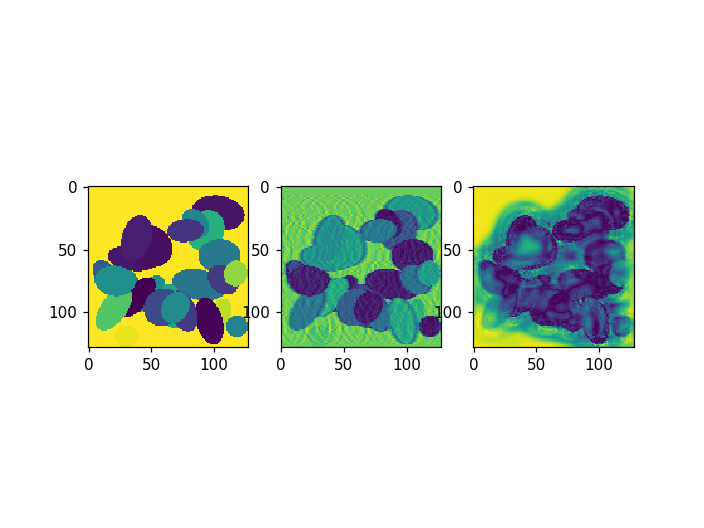

In [13]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3)
axs[0].imshow(np.squeeze(image))
axs[1].imshow(np.squeeze(res_z_filled))
axs[2].imshow(np.squeeze(res))

In [15]:
[l.alpha.numpy() for l in model.learnlet.threshold.thresholding_layers]

[array([0.12991482], dtype=float32),
 array([0.12110147], dtype=float32),
 array([0.10401861], dtype=float32)]

In [17]:
[a.numpy() for a in model.alphas]

[array([1.0039057], dtype=float32),
 array([1.0042788], dtype=float32),
 array([1.0091071], dtype=float32),
 array([1.0066142], dtype=float32),
 array([0.99543643], dtype=float32),
 array([0.99326044], dtype=float32),
 array([0.9943367], dtype=float32),
 array([0.9795294], dtype=float32),
 array([0.958928], dtype=float32),
 array([0.9612178], dtype=float32)]